In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.ndimage import uniform_filter1d as uniform

In [2]:
def to_date(date_str):
    return pd.to_datetime(date_str).date()
    
def date_to_timestamp(e):
    return datetime.datetime.timestamp(datetime.datetime(e.year, e.month, e.day))

def timestamp_to_date(e):
    return datetime.datetime.fromtimestamp(e).date()

def efficiency_at_date(date):
    return efficiency_at_timestamp(date_to_timestamp(date))

def efficiency_at_timestamp(timestamp):
    return timestamp * 1.13978483e-09 +  -1.44042555e+00

In [3]:
hashrate_history = pd.read_csv('data/hashrate.csv')[['Date(UTC)', 'Value']].values

In [4]:
# compute the power from the perspective of the utility provider
def compute_annual_power(
    hashrate, # ethereum network hashrate (megahashes per second)
    hashing_efficiency, # average hasing efficiency (megahashes per second per watt)
    hashing_efficiency_offset, # offset from mean hashing efficiency (megahashes per second per watt)
    gpu_power_ratio, # gpu power usage percentage relative to entire computer as a ratio from 0-1
    psu_efficiency, # average psu efficiency as a ratio from 0-1
    grid_efficiency, # average grid efficiency as a ratio from 0-1
    pue): # power usage effectiveness, accounting for cooling etc, 1.0+
    hashing_efficiency += hashing_efficiency_offset
    instant = (hashrate * pue) / (hashing_efficiency * gpu_power_ratio * psu_efficiency * grid_efficiency)
    annual = (instant * 365 * 24) / 1e12
    return annual

params = {
    'lower': { # best case scenario
        'hashing_efficiency_offset': 0.07,
        'gpu_power_ratio': 0.99,
        'psu_efficiency': 0.96,
        'grid_efficiency': 0.94,
        'pue': 1.01
    },
    'best': { # best guess
        'hashing_efficiency_offset': 0,
        'gpu_power_ratio': 0.95,
        'psu_efficiency': 0.7,
        'grid_efficiency': 0.92,
        'pue': 1.10
    },
    'upper': { # worst case scenario
        'hashing_efficiency_offset': -0.07,
        'gpu_power_ratio': 0.80,
        'psu_efficiency': 0.65,
        'grid_efficiency': 0.90,
        'pue': 1.20
    }
}

dates = []
results = defaultdict(list)
for date, hashrate_gh in hashrate_history:
    hashrate_mh = hashrate_gh * 1000
    date = to_date(date)
    hashing_efficiency = efficiency_at_date(date)
    
    for k,v in params.items():
        annual_power = compute_annual_power(hashrate_mh, hashing_efficiency, **v)
        results[k].append(annual_power)
    
    dates.append(date)
    
for k,v in results.items():
    results[k] = uniform(v, 7)

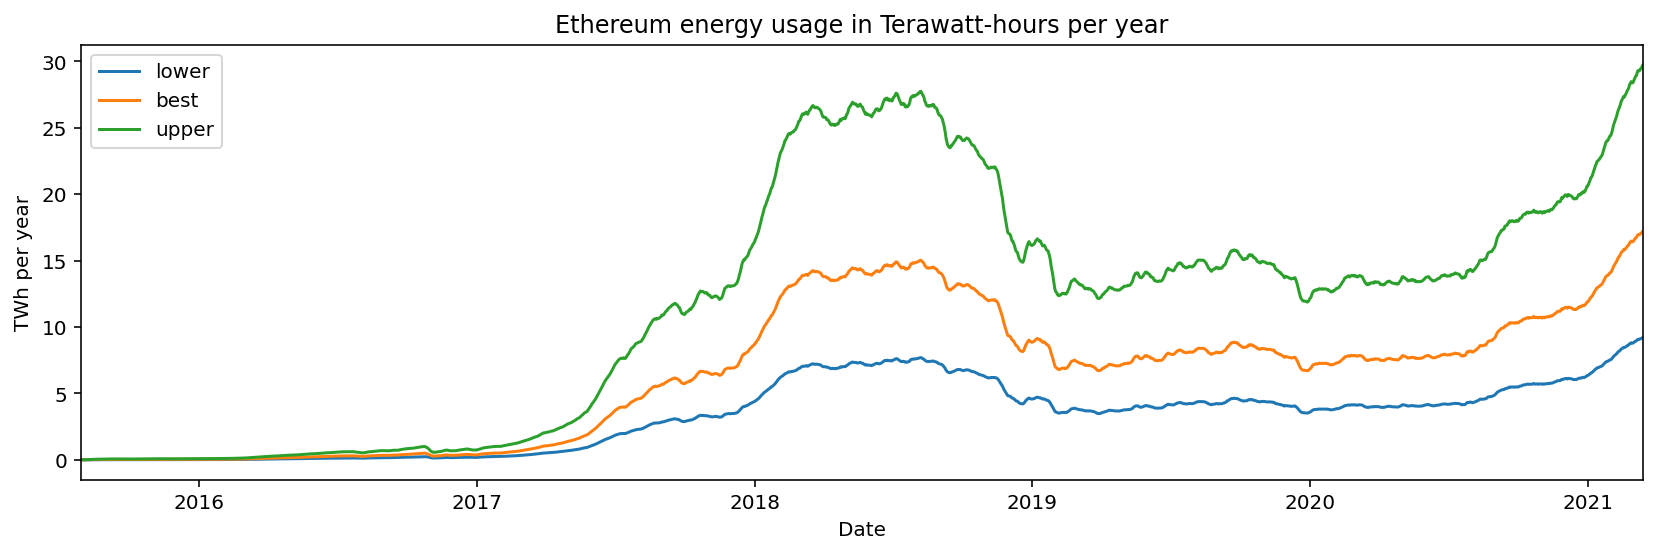

In [5]:
plt.figure(figsize=(14,4))
for k,v in results.items():
    plt.plot(dates, v, label=k)
plt.xlabel('Date')
plt.ylabel('TWh per year')
plt.title('Ethereum energy usage in Terawatt-hours per year')
plt.xlim(min(dates), max(dates))
plt.legend()
plt.show()

In [11]:
f"{results['best'][-1]:0.1f} TWh/year on {dates[-1]}"

'17.2 TWh/year on 2021-03-15'